In [1]:
%pylab inline
import numpy as np
from scipy.special import sph_harm, lpmv
import shtns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# SHT recurrence formula

SHTns computes SHT w/ an FFT on longitudes and recurrence formula for the Legendre transform on latitudes. See https://arxiv.org/abs/1202.6522 for more details.

Here's a testable / debuggable version of the recurrence formula

In [7]:
def gen_ml(N):
    return np.array([[m, l] for m in range(N+1) for l in range(N+1) if m<=l])

def all_amm(N):
    amm = []
    for m in range(N+1):
        els = []
        for k in range(1,m+1):
            els.append((2*k+1)/(2*k))
        el = np.prod(els)/(4*np.pi)
        amm.append(np.sqrt(el))
    amm = np.array(amm)
    return amm

def amn(m, n):
    nom = 4*n*n - 1
    den = n*n - m*m
    out = np.sqrt(nom/den)
    return out

def bmn(m, n):
    l = (2*n + 1)/(2*n - 3)
    r = ((n - 1)*(n - 1) - m*m)/(n*n - m*m)
    return - np.sqrt(l*r)

def lat_grid(nlat):
    x = np.r_[:nlat] / nlat * np.pi
    cx = np.cos(x)
    return cx

check_Pmn = lambda p, m, n, cx: \
    np.testing.assert_allclose(p, 
        sph_harm(m, n, 0, np.arccos(cx)).real, rtol=1e-5, atol=1e-6)

def eq13(N, m, n, amm_m, cx):
    p0 = amm_m*(1 - cx*cx)**(m/2)*(-1)**m
    stop = n == N
    check_Pmn(p0, m, m, cx)
    return stop, p0

def test_Pmn_recursion(N=10, nlat=32):
    "check all generated P^m_n(x) coefficients"
    amm = all_amm(N)
    cx = lat_grid(nlat)
    ml = set([(m_, l_) for (m_, l_) in gen_ml(N)])

    for m in range(N+1):

        n = m
        ml.remove((m,n))
        stop, p0 = eq13(N, m, n, amm[m], cx)
        if stop:
            break

        n += 1
        ml.remove((m,n))
        p1 = amn(m, n) * cx * p0 # eq 14
        check_Pmn(p1, m, n, cx)
        if n == N:
            continue

        n += 1
        ml.remove((m,n))
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0 # eq 15
        check_Pmn(p2, m, n, cx)
        if n == N:
            continue

        while n < N:
            p0, p1 = p1, p2
            n += 1
            ml.remove((m,n))
            p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0 # eq 15
            check_Pmn(p2, m, n, cx)
            print(m, n, p2.shape)

    assert(len(ml) == 0)

test_Pmn_recursion()

0 3 (32,)
0 4 (32,)
0 5 (32,)
0 6 (32,)
0 7 (32,)
0 8 (32,)
0 9 (32,)
0 10 (32,)
1 4 (32,)
1 5 (32,)
1 6 (32,)
1 7 (32,)
1 8 (32,)
1 9 (32,)
1 10 (32,)
2 5 (32,)
2 6 (32,)
2 7 (32,)
2 8 (32,)
2 9 (32,)
2 10 (32,)
3 6 (32,)
3 7 (32,)
3 8 (32,)
3 9 (32,)
3 10 (32,)
4 7 (32,)
4 8 (32,)
4 9 (32,)
4 10 (32,)
5 8 (32,)
5 9 (32,)
5 10 (32,)
6 9 (32,)
6 10 (32,)
7 10 (32,)


In [3]:
all_amm(10)
lat_grid(32)

array([ 1.00000000e+00,  9.95184727e-01,  9.80785280e-01,  9.56940336e-01,
        9.23879533e-01,  8.81921264e-01,  8.31469612e-01,  7.73010453e-01,
        7.07106781e-01,  6.34393284e-01,  5.55570233e-01,  4.71396737e-01,
        3.82683432e-01,  2.90284677e-01,  1.95090322e-01,  9.80171403e-02,
        6.12323400e-17, -9.80171403e-02, -1.95090322e-01, -2.90284677e-01,
       -3.82683432e-01, -4.71396737e-01, -5.55570233e-01, -6.34393284e-01,
       -7.07106781e-01, -7.73010453e-01, -8.31469612e-01, -8.81921264e-01,
       -9.23879533e-01, -9.56940336e-01, -9.80785280e-01, -9.95184727e-01])

In [4]:
test_Pmn_recursion()

0 3 (32,)
0 4 (32,)
0 5 (32,)
0 6 (32,)
0 7 (32,)
0 8 (32,)
0 9 (32,)
0 10 (32,)
1 4 (32,)
1 5 (32,)
1 6 (32,)
1 7 (32,)
1 8 (32,)
1 9 (32,)
1 10 (32,)
2 5 (32,)
2 6 (32,)
2 7 (32,)
2 8 (32,)
2 9 (32,)
2 10 (32,)
3 6 (32,)
3 7 (32,)
3 8 (32,)
3 9 (32,)
3 10 (32,)
4 7 (32,)
4 8 (32,)
4 9 (32,)
4 10 (32,)
5 8 (32,)
5 9 (32,)
5 10 (32,)
6 9 (32,)
6 10 (32,)
7 10 (32,)


All seems fine, let's do some timing with Numba to see how the JIT does with it, then Jax.

In [5]:
import numba

@numba.njit
def all_amm_jitable(amm_out):
    # N = amm_out.size - 1
    for m in range(amm_out.size):
        el = numba.float64(1.0)
        for k in range(1,m+1):
            el *= (2*k+1)/(2*k)
        el /= 4*np.pi
        amm_out[m] = np.sqrt(el)

        
amm1 = all_amm(70)
amm2 = np.zeros_like(amm1)
all_amm_jitable(amm2)
np.testing.assert_allclose(amm1, amm2)
%timeit all_amm(70)
%timeit all_amm_jitable(amm2)

408 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.14 µs ± 9.13 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
@numba.njit
def amn(m, n):
    nom = 4*n*n - 1
    den = n*n - m*m
    out = np.sqrt(nom/den)
    return out

@numba.njit
def bmn(m, n):
    l = (2*n + 1)/(2*n - 3)
    r = ((n - 1)*(n - 1) - m*m)/(n*n - m*m)
    return - np.sqrt(l*r)

def lat_grid(nlat):
    x = np.r_[:nlat] / nlat * np.pi
    cx = np.cos(x)
    return cx

So the recursion would look like this,

In [7]:
@numba.njit
def Pmn_recursion(amm, cx):
    N = amm.size - 1  # lmax
    nlat = cx.size
    # since cx is a vector, this is vectorized over latitudes
    for m in range(N+1):
        # eq 13
        n = m
        p0 = amm[m]*(1 - cx*cx)**(m/2)*(-1)**m
        if n == N:
            break
        # eq 14
        n += 1
        p1 = amn(m, n) * cx * p0
        if n == N:
            continue
        # eq 15 base case
        n += 1
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
        if n == N:
            continue
        # eq 15 iterate
        while n < N:
            p0, p1 = p1, p2
            n += 1
            p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0

But that doesn't do the transform, and it's easy to forgot exactly how it works, so let's step through it.  We need to input the FFT'd spatial data before walking through the Pmn recursion.

What does that look like? Let's take randn noise, truncated with the SHT, so it can be fully represented by the SHT:

In [8]:
sht = shtns.sht(lmax=31)
sht.set_grid(nlat=32, nphi=64)
x0 = sht.synth(sht.analys(np.random.randn(32,64)))
np.testing.assert_allclose(x0, sht.synth(sht.analys(x0)))

That field looks like this:

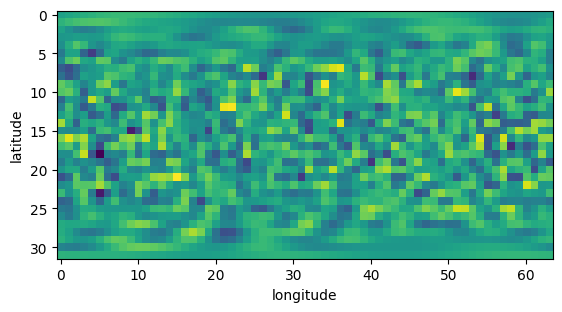

In [9]:
imshow(x0); xlabel('longitude'), ylabel('latitude');

Next is the FFT (for real valued data) over rows of this matrix, i.e. longitudes, i.e. an NFFT of length 64,

(<matplotlib.image.AxesImage at 0x12c20a6e0>,
 Text(0, 0.5, 'latitudes'),
 Text(0.5, 0, 'm (longitudinal frequencies)'))

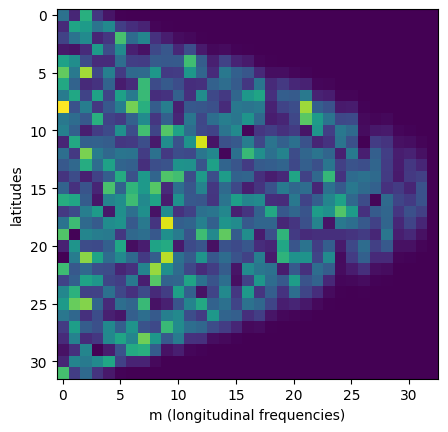

In [10]:
ft_x0 = np.fft.rfft(x0, axis=1)
imshow(np.abs(ft_x0)), ylabel('latitudes'), xlabel('m (longitudinal frequencies)')

The second transform is the Legendre transform on the columns of this matrix, though the result is not usually stored as a matrix (like for 2-D FFT).  For each SH mode (l, m), we need to take product of the Pmn coefficients with the matrix column.  In code,

In [11]:
len(gen_ml(31))

528

In [24]:
@numba.njit#(boundscheck=True)
def apply_pmn(p, x):
#     assert p.size == x.size, f'{p.size} != {x.size}'
    acc = numba.complex128(0.0)
    for i in range(x.size):
        acc += p[i] * x[i]
    return acc

@numba.njit#(boundscheck=True)
def sht_pmn_recur(q_out, ft_x, amm, cx):
    N = amm.size - 1  # lmax
    nlat = cx.size
    o = 0
    # since cx is a vector, this is vectorized over latitudes
    for m in range(N+1):
        # eq 13
        n = m
        p0 = amm[m]*(1 - cx*cx)**(m/2)*(-1)**m
        q_out[o] = apply_pmn(p0, ft_x[:,m]); o+=1
        if n == N:
            break
        # eq 14
        n += 1
        p1 = amn(m, n) * cx * p0
        q_out[o] = apply_pmn(p1, ft_x[:,m]); o+=1
        if n == N:
            continue
        # eq 15 base case
        n += 1
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
        q_out[o] = apply_pmn(p2, ft_x[:,m]); o+=1
        if n == N:
            continue
        # eq 15 iterate
        while n < N:
            p0, p1 = p1, p2
            n += 1
            p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
            q_out[o] = apply_pmn(p2, ft_x[:,m]); o+=1

lmax, nlat, nlon = 31, 32, 64
ft_x0 = np.fft.rfft(np.random.randn(nlat, nlon), axis=1)
q = np.zeros(len(gen_ml(lmax)), np.complex128)
cx = lat_grid(nlat)
amm = all_amm(lmax)
sht_pmn_recur(q, ft_x0, amm, cx)
%timeit sht_pmn_recur(q, ft_x0, amm, cx)

lmax, nlat, nlon = 127, 128, 256
ft_x0 = np.fft.rfft(np.random.randn(nlat, nlon), axis=1)
q = np.zeros(len(gen_ml(lmax)), np.complex128)
cx = lat_grid(nlat)
amm = all_amm(lmax)
sht_pmn_recur(q, ft_x0, amm, cx)
%timeit sht_pmn_recur(q, ft_x0, amm, cx)

62.5 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.16 ms ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Compare this with the matrix form,

In [27]:
import nfjax.shtlc as lc

lmax, nlat, nlon = 31, 32, 64
f1 = lc.make_shtdiff(lmax, nlat, nlon, -1e-4)
f2,_ = lc.make_shtdiff_jax(lmax, nlat, nlon, -1e-4)
x0 = np.random.randn(nlat, nlon)
print('benching')
f1(x0), f2(x0)
%timeit f1(x0)
%timeit f2(x0)

benching
43.9 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
30.9 µs ± 60.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
lmax, nlat, nlon = 127, 128, 256
f1 = lc.make_shtdiff(lmax, nlat, nlon, -1e-4)
f2,_ = lc.make_shtdiff_jax(lmax, nlat, nlon, -1e-4)
x0 = np.random.randn(nlat, nlon)

In [29]:
print('benching')
f1(x0), f2(x0)
%timeit f1(x0)
%timeit f2(x0)

benching
2.09 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.13 ms ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It seems that for very large grid sizes, the recurrence relations would scale better, but these sizes are likely larger than what we encounter in inference, since we need to keep the evaluation time.